In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 

In [54]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS = 20

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato_disease_dataset",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [53]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)


68

In [6]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow
    print (image_batch[0])

tf.Tensor(
[[[164. 159. 165.]
  [156. 151. 157.]
  [150. 145. 151.]
  ...
  [188. 186. 191.]
  [192. 190. 195.]
  [199. 197. 202.]]

 [[167. 162. 168.]
  [160. 155. 161.]
  [152. 147. 153.]
  ...
  [189. 187. 192.]
  [191. 189. 194.]
  [197. 195. 200.]]

 [[161. 156. 162.]
  [157. 152. 158.]
  [153. 148. 154.]
  ...
  [189. 187. 192.]
  [190. 188. 193.]
  [195. 193. 198.]]

 ...

 [[151. 146. 153.]
  [152. 147. 154.]
  [158. 153. 160.]
  ...
  [170. 167. 176.]
  [174. 171. 180.]
  [183. 180. 189.]]

 [[146. 141. 148.]
  [144. 139. 146.]
  [147. 142. 149.]
  ...
  [173. 170. 179.]
  [177. 174. 183.]
  [190. 187. 196.]]

 [[159. 154. 161.]
  [154. 149. 156.]
  [154. 149. 156.]
  ...
  [168. 165. 174.]
  [172. 169. 178.]
  [187. 184. 193.]]], shape=(256, 256, 3), dtype=float32)


In [7]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow
    print (image_batch[0].numpy())

[[[172. 170. 181.]
  [171. 169. 180.]
  [170. 168. 179.]
  ...
  [146. 144. 158.]
  [145. 143. 157.]
  [145. 143. 157.]]

 [[171. 169. 180.]
  [171. 169. 180.]
  [171. 169. 180.]
  ...
  [147. 145. 159.]
  [147. 145. 159.]
  [147. 145. 159.]]

 [[170. 168. 179.]
  [170. 168. 179.]
  [172. 170. 181.]
  ...
  [148. 146. 160.]
  [148. 146. 160.]
  [148. 146. 160.]]

 ...

 [[144. 143. 149.]
  [151. 150. 156.]
  [151. 150. 156.]
  ...
  [142. 141. 149.]
  [141. 140. 148.]
  [144. 143. 151.]]

 [[146. 145. 151.]
  [148. 147. 153.]
  [150. 149. 155.]
  ...
  [136. 135. 143.]
  [142. 141. 149.]
  [152. 151. 159.]]

 [[143. 142. 148.]
  [143. 142. 148.]
  [147. 146. 152.]
  ...
  [135. 134. 142.]
  [141. 140. 148.]
  [152. 151. 159.]]]


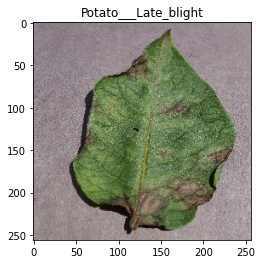

In [8]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])

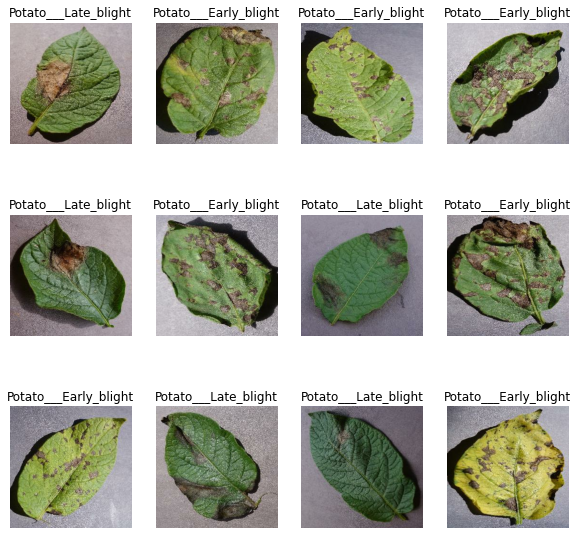

In [9]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [10]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=4)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds)

54

In [13]:
len(val_ds)

6

In [14]:
len(test_ds)

8

In [15]:
#cashing

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
#Divining by 255 (IMAGE PROCESSING)
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
#DATA Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])    

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),  
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [55]:
history=model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/20
54/54 [==============================] - 234s 4s/step - loss: 0.3530 - accuracy: 0.8628 - val_loss: 0.2953 - val_accuracy: 0.8802
Epoch 2/20
54/54 [==============================] - 236s 4s/step - loss: 0.2958 - accuracy: 0.8924 - val_loss: 1.3793 - val_accuracy: 0.6562
Epoch 3/20
54/54 [==============================] - 231s 4s/step - loss: 0.1927 - accuracy: 0.9253 - val_loss: 0.6258 - val_accuracy: 0.8125
Epoch 4/20
54/54 [==============================] - 227s 4s/step - loss: 0.1438 - accuracy: 0.9468 - val_loss: 0.1509 - val_accuracy: 0.9531
Epoch 5/20
54/54 [==============================] - 227s 4s/step - loss: 0.1203 - accuracy: 0.9566 - val_loss: 0.4571 - val_accuracy: 0.8333
Epoch 6/20
54/54 [==============================] - 228s 4s/step - loss: 0.1491 - accuracy: 0.9421 - val_loss: 0.5129 - val_accuracy: 0.8438
Epoch 7/20
54/54 [==============================] - 229s 4s/step - loss: 0.1420 - accuracy: 0.9433 - val_loss: 0.1821 - val_accuracy: 0.9375
Epoch 8/20
54

In [58]:
history

In [59]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 54}

In [60]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [61]:
acc=history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss=history.history['val_loss']

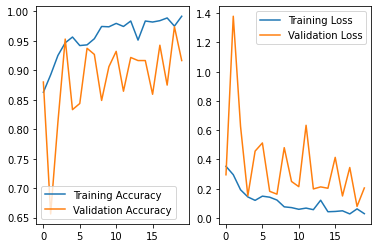

In [62]:
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend()

First Image
First label =  Potato___Early_blight
Predicted label =  Potato___Early_blight


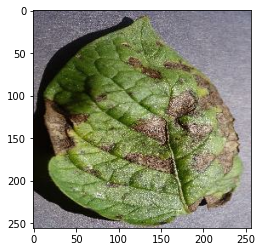

In [68]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First Image')
    plt.imshow(first_image)
    print('First label = ',class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print('Predicted label = ',class_names[np.argmax(batch_prediction[0])])

In [69]:
def predict(model,img):
    img_arr = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_arr = tf.expand_dims(img_arr,0) #created batch
    
    predictions=model.predict(img_arr)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence =  round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

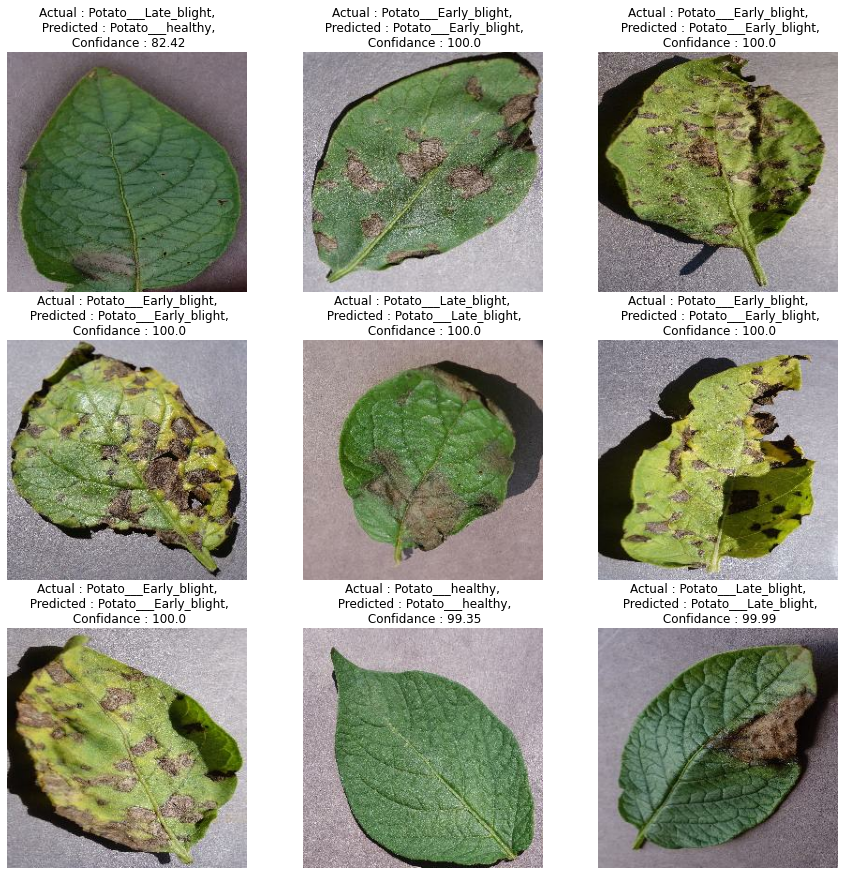

In [70]:
plt.figure(figsize=(15,15))

for images, labes in test_ds.take(1):
    for i in range(9):
        
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model,images[i].numpy())
        actuall_class= class_names[labes[i]]
        
        plt.title(f'Actual : {actuall_class},\n Predicted : {predicted_class},\n Confidance : {confidence}')
        
        plt.axis('off')

In [129]:
import os
os.listdir('../models')

[]

In [56]:
model_version=2
model.save(f'../models/{model_version}', save_format='h5')